# Prediction Analysis from Behavioral data

*Note:* Use local SLEAP's env

### Installing required packages

In [1]:
# !pip install h5py
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install sklearn
# !pip install numpy
# !pip install scipy
# !pip install sleap==1.2.6
# !pip install tables

### Importing packages

In [2]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.interpolate import interp1d

### Getting the data from Github (If you are using Colab)

In [3]:
# !wget -O prediction_analysis.h5 https://github.com/rdiazrincon/SLEAP_Data/blob/master/displacement_analysis/data/prediction_analysis.h5

### Gettting the data directly from the path

In [4]:
path = "data/prediction_analysis.h5"
intervals = "data/WL_info_by_timestamp.csv"

## Exploring the data

In [5]:
# Opening H5 file
with h5py.File(path, "r") as f:
    dataset_keys = list(f.keys())
    tracks = f["tracks"][:].T
    bodyparts = [n.decode() for n in f["node_names"][:]]

print("Filename: " + path)
print("Array keys: " + str(dataset_keys))
print("Behavioral data shape: " + str(tracks.shape))
print("Body parts: " + str(bodyparts))

Filename: data/prediction_analysis.h5
Array keys: ['edge_inds', 'edge_names', 'instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']
Behavioral data shape: (54546, 6, 2, 2)
Body parts: ['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']


Keys shape

“track_occupancy” (shape: tracks * frames)

“tracks” (shape: frames * nodes * 2 * tracks)

“track_names” (shape: tracks)

“bodyparts” (shape: nodes)

“edge_names” (shape: nodes - 1)

“edge_inds” (shape: nodes - 1)

“point_scores” (shape: frames * nodes * tracks)

“instance_scores” (shape: frames * tracks)

“tracking_scores” (shape: frames * tracks)

## Understanding the data 

We will mostly work with the tracks array. It contains information regarding Number of Frames, Number of Bodyparts, Number of Coordinates and Number of instances.


In [6]:
# Here's what each dimension of the matrix means
n_frames, n_bodyparts, n_coordinates, n_instances = tracks.shape

print("Number of Frames:", n_frames)
print("Number of Bodyparts:", n_bodyparts)
print("Number of Coordinates", n_coordinates)
print("NUmber of Instances:", n_instances)

Number of Frames: 54546
Number of Bodyparts: 6
Number of Coordinates 2
NUmber of Instances: 2


### Lets take a look at the data

#### First frame 

In [7]:
print(tracks[0])

[[[184.44789124 315.60144043]
  [351.55776978 379.87524414]]

 [[140.21481323 284.03588867]
  [364.47213745 367.95025635]]

 [[183.75314331 319.75219727]
  [404.18869019 427.59402466]]

 [[147.53791809 412.41549683]
  [208.04371643 216.35691833]]

 [[148.6204834  339.65484619]
  [324.4312439  299.75323486]]

 [[168.43464661 296.26281738]
  [367.9828186  387.65563965]]]


#### Forehead coordinates for both mouse in Frame 1

In [8]:
print(tracks[0][5])

[[168.43464661 296.26281738]
 [367.9828186  387.65563965]]


#### X-Forehead coordinate for both mouse in Frame 1

In [9]:
print(tracks[0][5][0])

[168.43464661 296.26281738]


#### X-Forehead coordinate for mouse 2 in Frame 1.

In [10]:
print(tracks[0][5][0][1]) 

296.2628173828125


Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

We won't drop the NaN values but will fill them with Non Zero values so the analysis is easier to make

In [11]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [12]:
tracks = fill_missing(tracks)
print(tracks.shape)


(54546, 6, 2, 2)


In [13]:
df = pd.DataFrame(np.array(h5py.File(path)['track_occupancy']))
# df = pd.DataFrame(np.array(tracks[555][0]))
df

,0,1
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
54541,1,1
54542,1,1
54543,1,1
54544,1,1


In [14]:
# Reading information related to the frames that make up a Trial
df_trials = pd.read_csv(intervals)['Frame']
df_trials

0       2100-2400
1       4470-4770
2       7140-7440
3       9510-9810
4     11730-12030
5     14670-14970
6     17520-17820
7     20160-20460
8     22530-22830
9     25200-25500
10    28140-28440
11    30840-31140
12    34410-34710
13    37050-37350
14    39570-39870
15    42210-42510
16    45030-45330
17    48600-48900
18    50970-51270
19    53790-54090
Name: Frame, dtype: object

In [15]:
trials_array_separated = [trial.split("-") for trial in df_trials]
trials_array = []
for i in range(len(trials_array_separated)):
    for j in trials_array_separated[i]:
        trials_array.append(eval(j)) # Converting strs to in in array
        
trials_array

[2100,
 2400,
 4470,
 4770,
 7140,
 7440,
 9510,
 9810,
 11730,
 12030,
 14670,
 14970,
 17520,
 17820,
 20160,
 20460,
 22530,
 22830,
 25200,
 25500,
 28140,
 28440,
 30840,
 31140,
 34410,
 34710,
 37050,
 37350,
 39570,
 39870,
 42210,
 42510,
 45030,
 45330,
 48600,
 48900,
 50970,
 51270,
 53790,
 54090]

## Visualize nose movement across whole video video

In progress: Identify which frame corresponds to which minute/second of the video and analyze those chunks separately

In [21]:
LEFT_EAR_INDEX = 0
RIGHT_EAR_INDEX = 1
NOSE_INDEX = 2
TAIL_BASE_INDEX = 3
THORAX_INDEX = 4
FOREHEAD_INDEX = 5
n_trials = 20
frames_per_trial = 300
left_ear_loc_aux = []
right_ear_loc_aux = []
nose_loc_aux = []
tail_base_loc_aux = []
thorax_loc_aux = []
forehead_loc_aux = []

iterator = iter(trials_array)
for i, j in zip(iterator, iterator):
    left_ear_loc_aux.append(tracks[i:j, LEFT_EAR_INDEX, :, :])
    right_ear_loc_aux.append(tracks[i:j, RIGHT_EAR_INDEX, :, :])
    nose_loc_aux.append(tracks[i:j, NOSE_INDEX, :, :])
    tail_base_loc_aux.append(tracks[i:j, TAIL_BASE_INDEX, :, :])
    thorax_loc_aux.append(tracks[i:j, THORAX_INDEX, :, :])
    forehead_loc_aux.append(tracks[i:j, FOREHEAD_INDEX, :, :])

left_ear_loc = np.asarray(left_ear_loc_aux).reshape(n_trials*frames_per_trial, n_coordinates, n_instances)
right_ear_loc = np.asarray(right_ear_loc_aux).reshape(n_trials*frames_per_trial, n_coordinates, n_instances)
nose_loc = np.asarray(nose_loc_aux).reshape(n_trials*frames_per_trial, n_coordinates, n_instances)
tail_base_loc = np.asarray(tail_base_loc_aux).reshape(n_trials*frames_per_trial, n_coordinates, n_instances)
thorax_loc = np.asarray(thorax_loc_aux).reshape(n_trials*frames_per_trial, n_coordinates, n_instances)
forehead_loc = np.asarray(forehead_loc_aux).reshape(n_trials*frames_per_trial, n_coordinates, n_instances)

### Converting our data into a Tabular format

In [22]:
# There is an easier way of doing this but I don't have the time now

df = pd.DataFrame({
    'm1_left_ear_x': left_ear_loc[:, 0, 0], 
    'm1_left_ear_y': left_ear_loc[:, 1, 0], 
    "m2_left_ear_x": left_ear_loc[:, 0, 1],
    "m2_left_ear_y": left_ear_loc[:, 1, 1],

    'm1_right_ear_x': right_ear_loc[:, 0, 0], 
    'm1_right_ear_y': right_ear_loc[:, 1, 0], 
    "m2_right_ear_x": right_ear_loc[:, 0, 1],
    "m2_right_ear_y": right_ear_loc[:, 1, 1],
    
    'm1_nose_x': nose_loc[:, 0, 0], 
    'm1_nose_y': nose_loc[:, 1, 0], 
    "m2_nose_x": nose_loc[:, 0, 1],
    "m2_nose_y": nose_loc[:, 1, 1],

    'm1_tail_base_x': tail_base_loc[:, 0, 0], 
    'm1_tail_base_y': tail_base_loc[:, 1, 0], 
    "m2_tail_base_x": tail_base_loc[:, 0, 1],
    "m2_tail_base_y": tail_base_loc[:, 1, 1],

    'm1_thorax_x': thorax_loc[:, 0, 0], 
    'm1_thorax_y': thorax_loc[:, 1, 0], 
    "m2_thorax_x": thorax_loc[:, 0, 1],
    "m2_thorax_y": thorax_loc[:, 1, 1],

    'm1_forehead_x': forehead_loc[:, 0, 0], 
    'm1_forehead_y': forehead_loc[:, 1, 0], 
    "m2_forehead_x": forehead_loc[:, 0, 1],
    "m2_forehead_y": forehead_loc[:, 1, 1],
    })
df

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
0,435.738861,352.499847,323.723297,383.477448,383.478302,360.201538,279.483582,380.419403,407.676056,411.734283,...,168.406693,264.279053,412.323761,304.237610,267.927094,327.594879,408.483521,372.384155,303.970581,395.865784
1,435.784668,352.405945,323.433044,380.188843,380.464661,360.105408,276.471832,380.382233,407.424866,408.140869,...,176.274780,255.662704,411.919312,307.888336,267.596588,327.751221,408.483765,372.294464,303.810272,395.767853
2,432.359528,352.400665,323.640228,380.157562,380.184784,360.052612,279.543304,379.897522,407.869415,411.647339,...,191.850571,243.927917,412.211121,304.222229,267.974335,324.273773,408.168640,372.250824,303.902740,395.667236
3,432.411316,352.264740,323.588898,380.525604,379.999359,359.774841,279.689240,379.784027,408.336761,412.075745,...,191.849289,244.375793,415.669556,303.965393,272.078674,323.633698,408.170624,372.105011,303.799622,395.781982
4,435.479797,352.146271,323.533112,383.891266,379.873260,359.761688,279.641327,380.162628,408.322693,411.968201,...,191.922699,247.480423,412.267731,304.296906,275.579651,323.618439,408.156128,372.109406,303.730347,396.000549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,324.019257,380.543854,236.562531,372.530457,280.293396,380.155640,196.307007,388.662689,311.529327,424.361389,...,147.436615,247.510895,276.144226,316.085999,188.056274,323.609253,304.295227,396.221283,220.535690,392.273529
5996,324.042328,380.474396,239.551392,372.427856,280.374542,380.007629,196.401520,388.597717,311.558105,424.339417,...,147.521362,247.523239,276.180511,316.004486,188.214462,323.876678,304.328369,396.156708,223.614609,392.170624
5997,323.935272,380.598358,239.575912,372.512695,279.937714,380.215118,196.347336,391.510345,311.636200,424.192688,...,147.458389,247.574310,276.176422,315.910980,188.025620,323.849854,304.205322,396.180847,223.655334,392.270782
5998,323.913208,383.466827,239.627777,372.315765,279.882599,380.290009,196.493118,388.663361,311.634827,424.190430,...,144.364548,247.583237,276.189575,315.953705,187.900620,323.686401,304.202362,396.210602,223.748444,392.159973


In [23]:
type(df)

pandas.core.frame.DataFrame

### Further exploration of the data

In [24]:
df.describe()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,310.306263,339.968582,311.120466,352.018595,277.345881,354.200103,274.635682,362.794023,310.851809,376.279241,...,239.850267,236.526251,270.027531,304.996826,269.795693,308.799318,298.795792,355.236411,297.220200,366.640914
std,61.237502,65.784512,62.757648,39.156334,63.465888,70.830769,67.349422,42.905859,53.836216,73.700563,...,99.444207,43.061514,75.412112,56.512654,76.240505,36.588299,59.395044,67.522753,61.491687,39.623328
min,60.720242,8.605143,52.018154,180.502060,36.420036,56.803680,19.914917,163.947571,67.964470,31.354719,...,43.695873,132.537537,67.939507,56.133495,48.116600,179.929245,60.334515,48.002243,35.576023,195.755096
25%,290.052831,324.197769,291.747086,335.920990,259.632828,342.222352,252.155239,340.305298,291.994209,363.550352,...,160.358124,204.416969,231.522293,287.823029,228.032742,283.881065,280.935013,340.693396,280.008560,347.590935
50%,316.520554,360.301559,319.371811,363.995377,279.968628,372.437424,279.548141,371.714737,312.072784,407.874695,...,239.932358,231.622299,259.680527,319.789001,264.035019,316.180161,300.329727,383.764252,299.886215,383.746658
75%,324.019348,380.158493,323.883438,380.497375,288.011284,392.483154,284.247383,388.455658,328.299965,420.018509,...,276.417442,269.894036,296.278290,339.778381,296.358788,332.088989,312.490585,395.600937,311.527481,392.485291
max,619.810852,432.281860,623.541565,427.442749,630.346130,443.735901,627.367554,448.298676,628.049438,435.704102,...,552.500610,360.147125,612.270691,403.905762,608.155334,415.644318,620.393127,424.015686,623.828247,424.100983


In [25]:
df.sample()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
1259,476.297577,184.067444,316.455627,384.531952,432.084503,168.039185,283.78775,368.147308,443.449402,219.836975,...,331.806854,211.954987,483.518066,111.905609,308.186523,319.859375,451.867065,188.390167,296.508667,391.566498


In [26]:
df.value_counts()

m1_left_ear_x  m1_left_ear_y  m2_left_ear_x  m2_left_ear_y  m1_right_ear_x  m1_right_ear_y  m2_right_ear_x  m2_right_ear_y  m1_nose_x   m1_nose_y   m2_nose_x   m2_nose_y   m1_tail_base_x  m1_tail_base_y  m2_tail_base_x  m2_tail_base_y  m1_thorax_x  m1_thorax_y  m2_thorax_x  m2_thorax_y  m1_forehead_x  m1_forehead_y  m2_forehead_x  m2_forehead_y
60.720242      388.722046     323.602295     368.474762     50.649914       382.703430      283.578918      355.862640      91.498985   416.717814  308.135468  420.345367  67.617310       256.059326      332.370056      211.608322      76.196129    335.888458   307.668701   312.066772   77.580564      395.714762     300.102509     379.919891       1
323.527252     360.109314     355.861115     252.128082     283.507507      384.118408      296.446045      271.821869      327.474457  419.708191  335.968475  295.769287  155.799103      283.558563      255.839951      147.634537      255.636810   328.195770   295.623138   211.778534   311.683716   

In [31]:
df2 = pd.read_csv(intervals)['Winner (1:M_1,0:M_2,2:Tie)']
df2

0     1
1     2
2     0
3     1
4     2
5     2
6     2
7     0
8     2
9     2
10    1
11    2
12    1
13    0
14    0
15    0
16    2
17    2
18    2
19    0
Name: Winner (1:M_1,0:M_2,2:Tie), dtype: int64

In [34]:
features_array = df2.to_numpy().repeat(frames_per_trial)
print(features_array)

[1 1 1 ... 0 0 0]


### Running Random Forest for prediction

In [35]:
X = df
Y = features_array

In [36]:
X.shape

(6000, 24)

In [37]:
Y.shape

(6000,)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [39]:
model = RandomForestClassifier(n_estimators = 10, random_state = 30)

In [40]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=30)

In [41]:
prediction_test = model.predict(X_test)
prediction_test

array([2, 0, 2, ..., 2, 0, 0])

In [42]:
prediction_probability = model.predict_proba(X_test)
prediction_probability

array([[0.1, 0. , 0.9],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       ...,
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0.9, 0. , 0.1]])

In [143]:
print (f"Accuracy: {metrics.accuracy_score(y_test, prediction_test):.2f}")

Accuracy: 0.96


In [44]:
print(model.score(X_test, y_test))

0.9641666666666666


In [125]:
confusion_matrix = pd.DataFrame({"Predicted Class Label": np.array(prediction_test), "Actual Class Label": np.array(y_test),})
confusion_matrix

,Predicted Class Label,Actual Class Label
0,2,2
1,0,0
2,2,2
3,2,2
4,0,0
...,...,...
1195,1,1
1196,2,2
1197,2,2
1198,0,0


In [47]:
feature_list = list(X.columns)
feature_list

['m1_left_ear_x',
 'm1_left_ear_y',
 'm2_left_ear_x',
 'm2_left_ear_y',
 'm1_right_ear_x',
 'm1_right_ear_y',
 'm2_right_ear_x',
 'm2_right_ear_y',
 'm1_nose_x',
 'm1_nose_y',
 'm2_nose_x',
 'm2_nose_y',
 'm1_tail_base_x',
 'm1_tail_base_y',
 'm2_tail_base_x',
 'm2_tail_base_y',
 'm1_thorax_x',
 'm1_thorax_y',
 'm2_thorax_x',
 'm2_thorax_y',
 'm1_forehead_x',
 'm1_forehead_y',
 'm2_forehead_x',
 'm2_forehead_y']

In [48]:
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

m2_tail_base_y    0.097375
m2_tail_base_x    0.091499
m2_thorax_x       0.080783
m1_tail_base_x    0.062044
m1_tail_base_y    0.055477
m2_nose_x         0.044594
m2_nose_y         0.039677
m1_thorax_x       0.038859
m2_thorax_y       0.037050
m2_right_ear_x    0.036991
m1_right_ear_x    0.035990
m1_nose_x         0.034496
m1_right_ear_y    0.034437
m2_right_ear_y    0.034132
m2_forehead_y     0.031625
m1_left_ear_y     0.031125
m2_forehead_x     0.030882
m1_nose_y         0.030469
m1_forehead_y     0.030180
m2_left_ear_y     0.028495
m1_thorax_y       0.025706
m1_left_ear_x     0.024086
m1_forehead_x     0.022146
m2_left_ear_x     0.021880
dtype: float64

[Text(0.5, 87.37999999999997, 'Predicted Labels'),
 Text(48.5, 0.5, 'True Labels')]

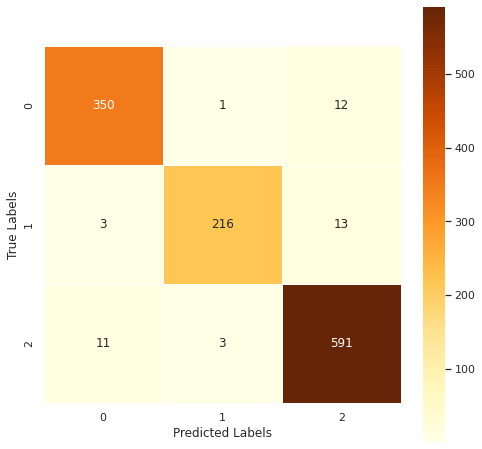

In [113]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_test)
sns.set(rc={'figure.figsize':(8,8)})
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="RdBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')

In [49]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Nose tracks across frames')

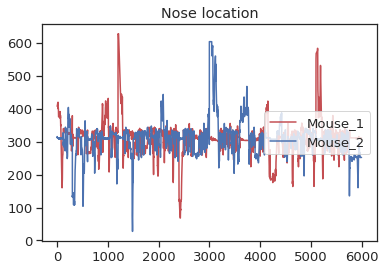

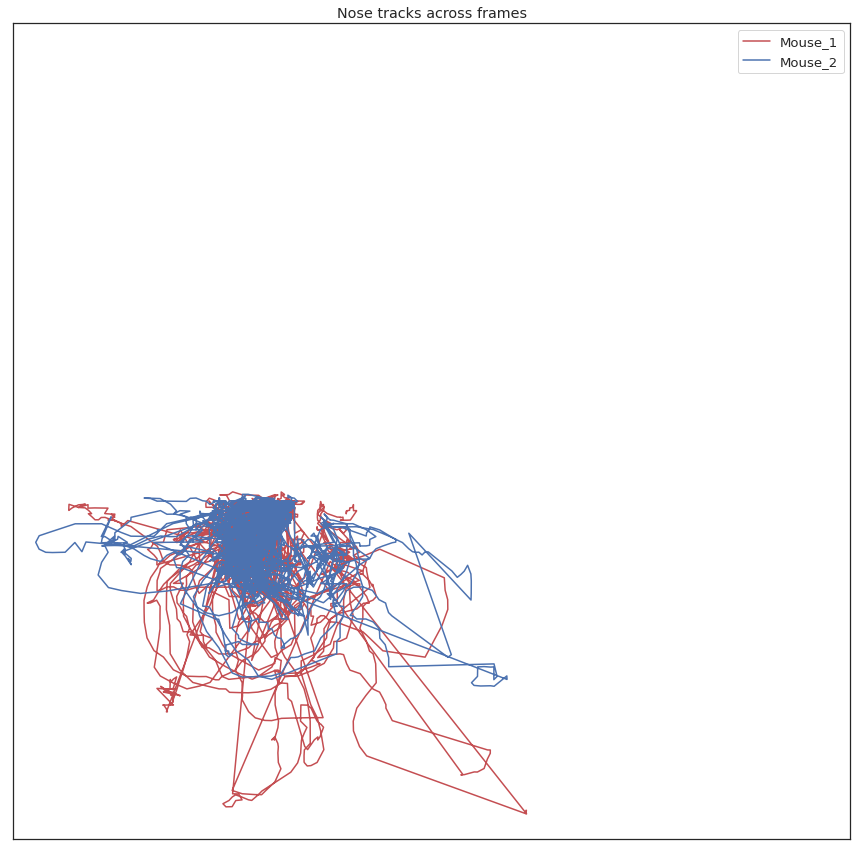

In [50]:
# Figure 1
plt.figure()

plt.plot(nose_loc[:,0,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1], 'b',label='Mouse_2')
# plt.plot(-1*nose_loc[:,1,0], 'r')
# plt.plot(-1*nose_loc[:,1,1], 'b')

plt.legend(loc="center right")

plt.title('Nose location')

# Figure 2
plt.figure(figsize=(15,15))

plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1],nose_loc[:,1,1], 'b',label='Mouse_2')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Nose tracks across frames')

## More advanced visualizations (In Progress)

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [51]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two mice. Let's get results for each separately.

In [52]:
thx_vel_mouse1 = smooth_diff(thorax_loc[:, :, 0])
thx_vel_mouse2 = smooth_diff(thorax_loc[:, :, 1])

### Visualizing thorax x-y dynamics and velocity for Mouse_1

Text(0.5, 1.0, 'Velocity')

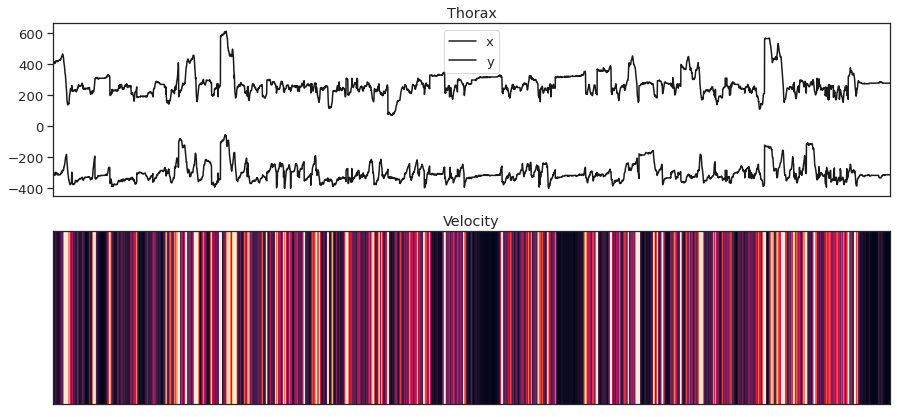

In [53]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
# Using the Transpose of the Matrix
ax2.imshow(thx_vel_mouse1[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of Mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of Mouse speed')

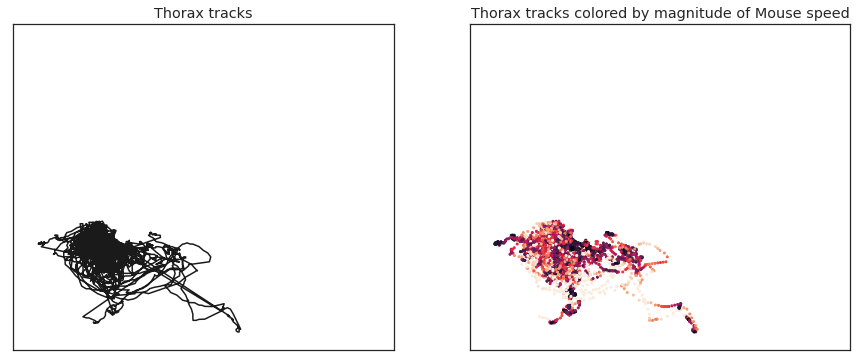

In [54]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_mouse1 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of Mouse speed')

### Find covariance in thorax velocities between Mouse_1 and Mouse_2

In [55]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

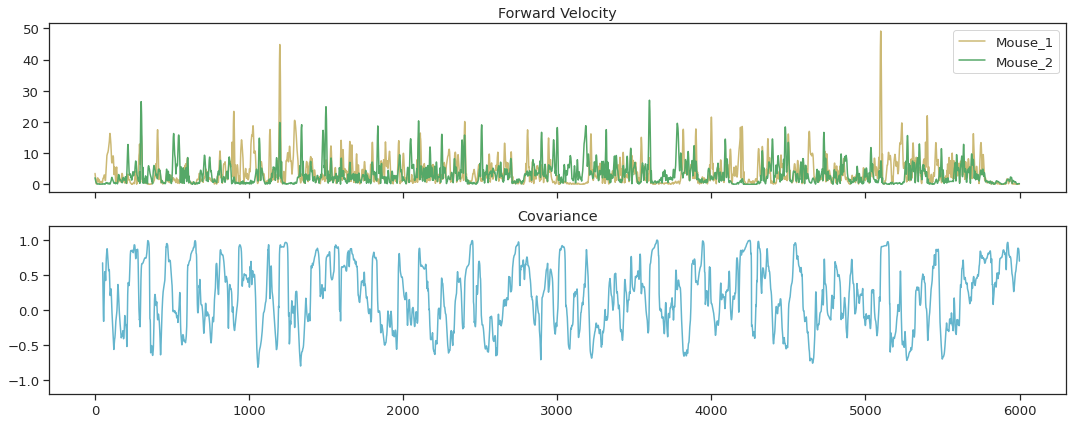

In [56]:
win = 50

cov_vel = corr_roll(thx_vel_mouse1, thx_vel_mouse2,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_mouse1, 'y', label='Mouse_1')
ax[0].plot(thx_vel_mouse2, 'g', label='Mouse_2')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

### Todo:
- Use frame rate (30) to correlate have an intuition of which set of frames correspond to which minute/second in the video

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run k-means on the velocities from each frame.


In [57]:
def instance_node_velocities(instance_idx):
    mouse_node_tracks = tracks[:, :, :, instance_idx]
    mouse_node_velocities = np.zeros((n_frames, n_bodyparts))

    for n in range(0, n_bodyparts):
        mouse_node_velocities[:, n] = smooth_diff(mouse_node_tracks[:, n, :])
    
    return mouse_node_velocities

In [58]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(n_bodyparts), bodyparts, rotation=20);
    plt.title(f'Mouse {instance_idx} node velocities')

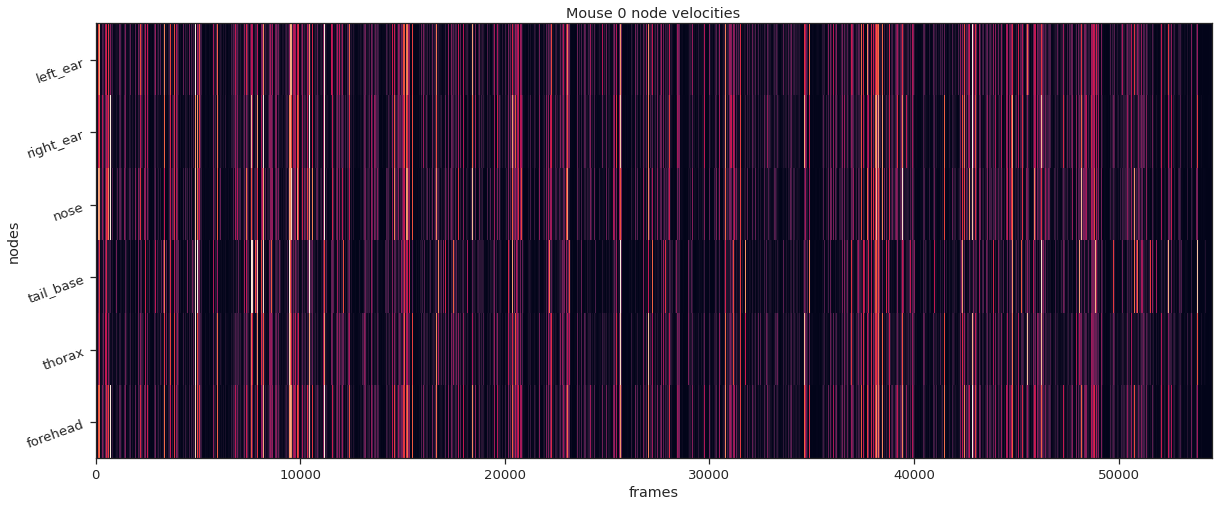

In [59]:
mouse_ID = 0
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

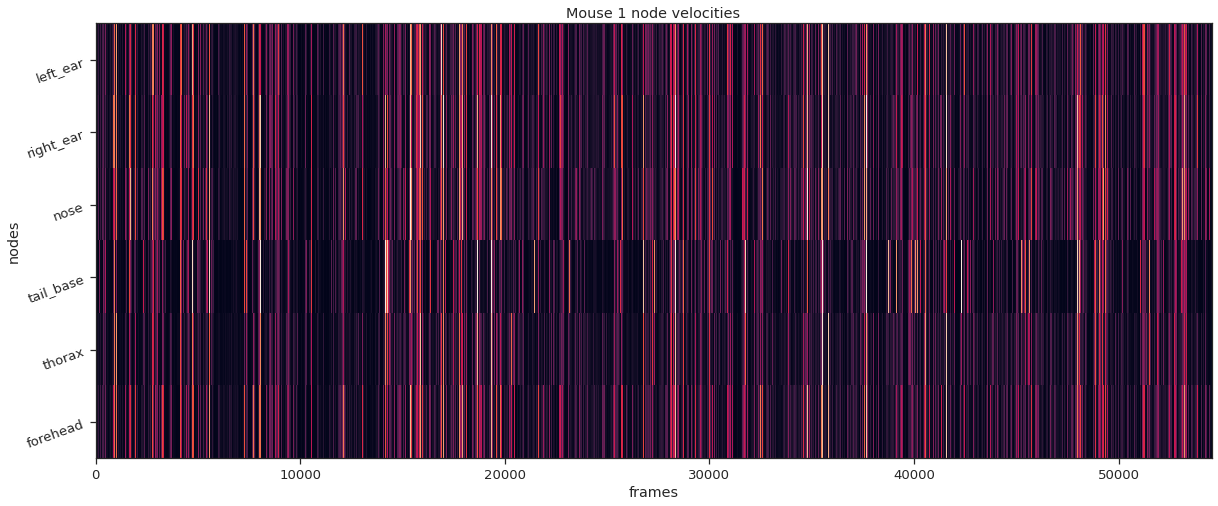

In [60]:
mouse_ID = 1
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

In [61]:
from sklearn.cluster import KMeans

In [62]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(mouse_node_velocities)

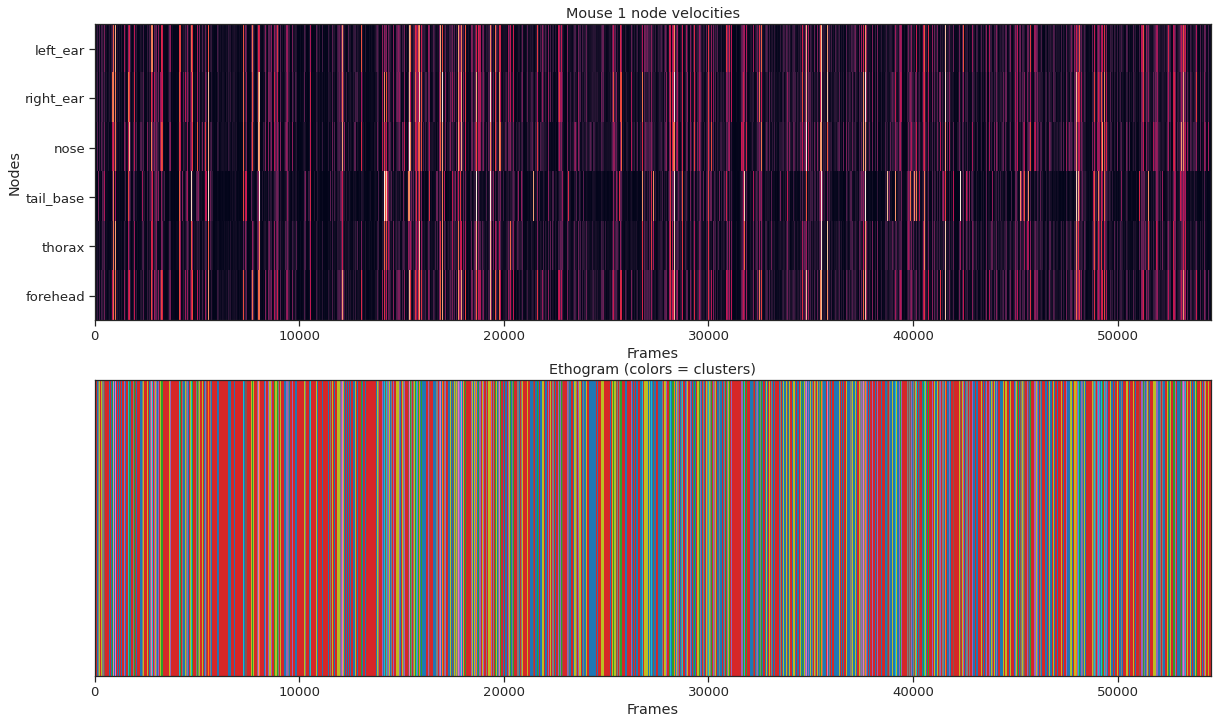

In [63]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(mouse_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(n_bodyparts))
ax1.set_yticklabels(bodyparts);
ax1.set_title(f"Mouse {mouse_ID} node velocities")
ax1.set_xlim(0,n_frames)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");